In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

## Random 充電/放電結果

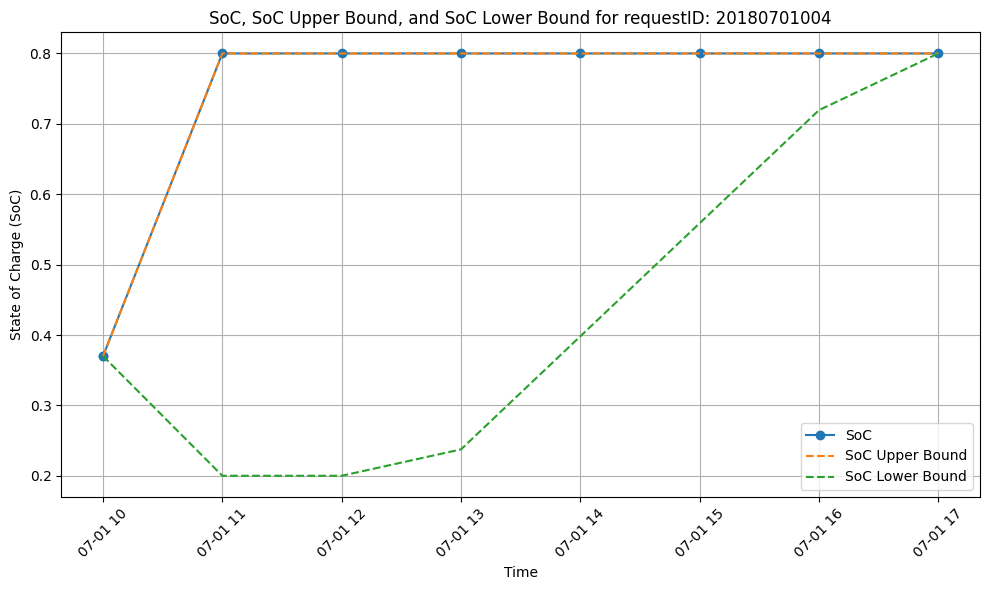

In [22]:
# Read the CSV file
file_path = './Result/Unschedule/1/soc_history.csv'
data = pd.read_csv(file_path)

# Convert 'current_time' to datetime
data['current_time'] = pd.to_datetime(data['current_time'])

# Function to plot SoC, SoC_upper_bound, and SoC_lower_bound for a given requestID
def plot_soc_for_requestID(requestID):
    filtered_data = data[data['requestID'] == requestID]
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(filtered_data['current_time'], filtered_data['soc'], label='SoC', marker='o')
    plt.plot(filtered_data['current_time'], filtered_data['SoC_upper_bound'], label='SoC Upper Bound', linestyle='--')
    plt.plot(filtered_data['current_time'], filtered_data['SoC_lower_bound'], label='SoC Lower Bound', linestyle='--')
    
    plt.xlabel('Time')
    plt.ylabel('State of Charge (SoC)')
    plt.title(f'SoC, SoC Upper Bound, and SoC Lower Bound for requestID: {requestID}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.show()

# Example usage 
plot_soc_for_requestID(20180701004)  # Replace with the desired requestID


## MARL 充電/放電結果

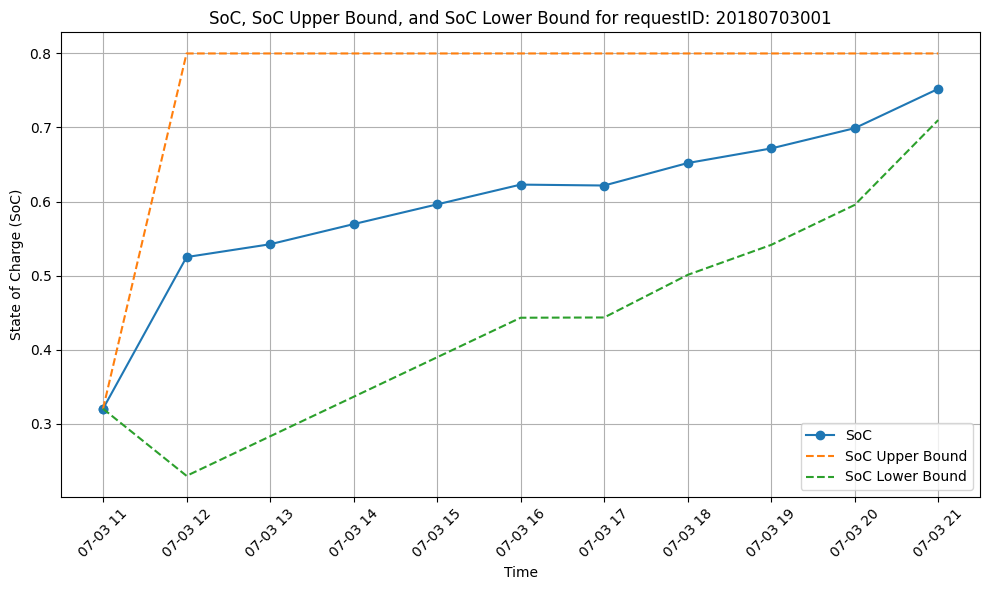

In [16]:
# Read the CSV file
file_path = './Result/MADDPG/291/soc_history.csv'
data = pd.read_csv(file_path)

# Convert 'current_time' to datetime
data['current_time'] = pd.to_datetime(data['current_time'])

# Function to plot SoC, SoC_upper_bound, and SoC_lower_bound for a given requestID
def plot_soc_for_requestID(requestID):
    filtered_data = data[data['requestID'] == requestID]
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(filtered_data['current_time'], filtered_data['soc'], label='SoC', marker='o')
    plt.plot(filtered_data['current_time'], filtered_data['SoC_upper_bound'], label='SoC Upper Bound', linestyle='--')
    plt.plot(filtered_data['current_time'], filtered_data['SoC_lower_bound'], label='SoC Lower Bound', linestyle='--')
    
    plt.xlabel('Time')
    plt.ylabel('State of Charge (SoC)')
    plt.title(f'SoC, SoC Upper Bound, and SoC Lower Bound for requestID: {requestID}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.show()

# Example usage
plot_soc_for_requestID(20180703001)  # Replace with the desired requestID


## 原始負載與 EV 充放電的負載變化圖

In [10]:
def plot_load_history(file_path, start_date, end_date):
    # Read load history from CSV
    load_history_df = pd.read_csv(file_path, parse_dates=['current_time'])
    
    # Filter data by date range
    mask = (load_history_df['current_time'] >= start_date) & (load_history_df['current_time'] <= end_date)
    filtered_df = load_history_df.loc[mask]
    
    # Plot original load and total load as bar charts
    plt.figure(figsize=(14, 7))
    bar_width = 0.4
    bar_positions = range(len(filtered_df))
    
    plt.bar(bar_positions, filtered_df['original_load'], width=bar_width, label='Original Load', color='blue')
    plt.bar([p + bar_width for p in bar_positions], filtered_df['total_load'], width=bar_width, label='Load after Charging/Discharging', color='red')
    
    plt.xlabel('Time')
    plt.ylabel('Load (kWh)')
    plt.title('Building Load: Original vs After Charging/Discharging')
    plt.xticks([p + bar_width/2 for p in bar_positions], filtered_df['current_time'].dt.strftime('%Y-%m-%d %H:%M:%S'), rotation=90)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

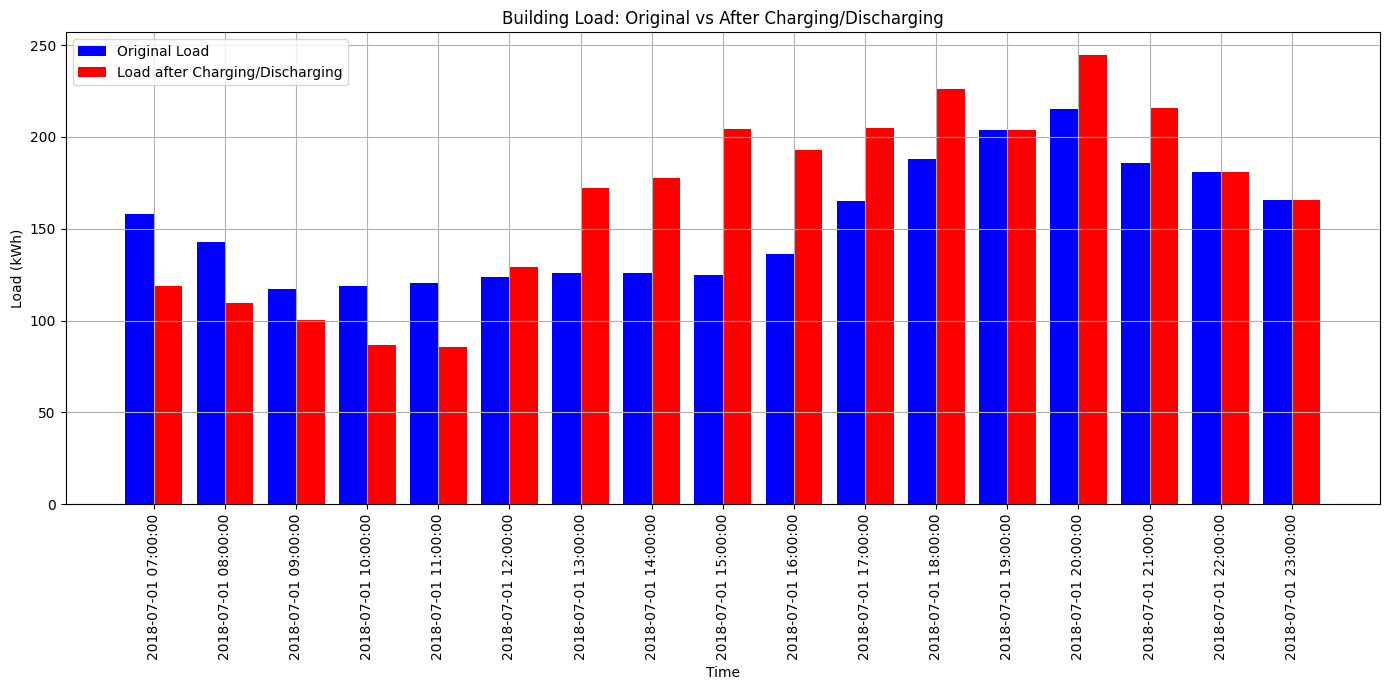

In [13]:
file_path = './Result/TEST/3/building_loading_history.csv'  # Modify this to the path of your load history file
start_date = '2018-07-01'
end_date = '2018-07-02'

# Convert string dates to datetime objects
start_date = datetime.strptime(start_date, '%Y-%m-%d')
end_date = datetime.strptime(end_date, '%Y-%m-%d')

plot_load_history(file_path, start_date, end_date)

## 計算峰谷比 (Peak-to-Valley Ratio)

In [42]:
start_date = '2018-07-01'
end_date = '2018-07-01'
start_hour = 8
end_hour = 18

start_time = datetime.strptime(f'{start_date} {start_hour}:00:00', '%Y-%m-%d %H:%M:%S')
end_time = datetime.strptime(f'{end_date} {end_hour}:00:00', '%Y-%m-%d %H:%M:%S')

In [44]:
df = pd.read_csv('./Result/MADDPG/68/building_loading_history.csv', parse_dates=['current_time'])
df['current_time'] = pd.to_datetime(df['current_time'])

def calculate_peak_to_valley_ratio(df, start_time, end_time):
    
    mask = (df['current_time'] >= start_time) & (df['current_time'] <= end_time)
    df_filtered = df[mask]

    max_load = df_filtered['total_load'].max()
    min_load = df_filtered['total_load'].min()

    # calculate peak to valley ratio
    peak_to_valley_ratio = max_load / min_load
    return peak_to_valley_ratio

In [45]:
ratio = calculate_peak_to_valley_ratio(df, start_time, end_time)
print(f'Peak-to-Valley Ratio from {start_time} to {end_time}: {ratio:.2f}')

Peak-to-Valley Ratio from 2018-07-01 08:00:00 to 2018-07-01 18:00:00: 2.78


## 計算建物使用電網用電的電力成本

In [135]:
def get_tou_price(current_time: datetime):
    
    tou_price = []
    if current_time.weekday() < 5:
        tou_price = [0.056] * 8 + [0.092] * 4 + [0.267] * 6 + [0.092] * 5 + [0.056] * 1
    else:
        tou_price = [0.056] * 24      
    return tou_price

In [136]:
def calculate_cost(df, start_time, end_time):
    # filter data by time range
    mask = (df['current_time'] >= start_time) & (df['current_time'] <= end_time)
    df_filtered = df.loc[mask].copy() 

    # calculate hour, tou_price, and hourly_cost
    df_filtered['hour'] = df_filtered['current_time'].dt.hour
    df_filtered['tou_price'] = df_filtered['current_time'].apply(lambda x: get_tou_price(x)[x.hour])
    df_filtered['hourly_cost'] = df_filtered['total_load'] * df_filtered['tou_price']

    # calculate total cost
    total_cost = df_filtered['hourly_cost'].sum()

    return df_filtered, total_cost

In [137]:
def visualize_cost(df_filtered):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=df_filtered['current_time'], y=df_filtered['hourly_cost'], palette="viridis")
    plt.xticks(rotation=45)
    plt.xlabel('Time')
    plt.ylabel('Hourly Cost')
    plt.title('Hourly Cost Over Time')
    plt.grid(True)
    plt.show()


Total Cost from 2018-07-01 08:00:00 to 2018-07-01 18:00:00: 92.44


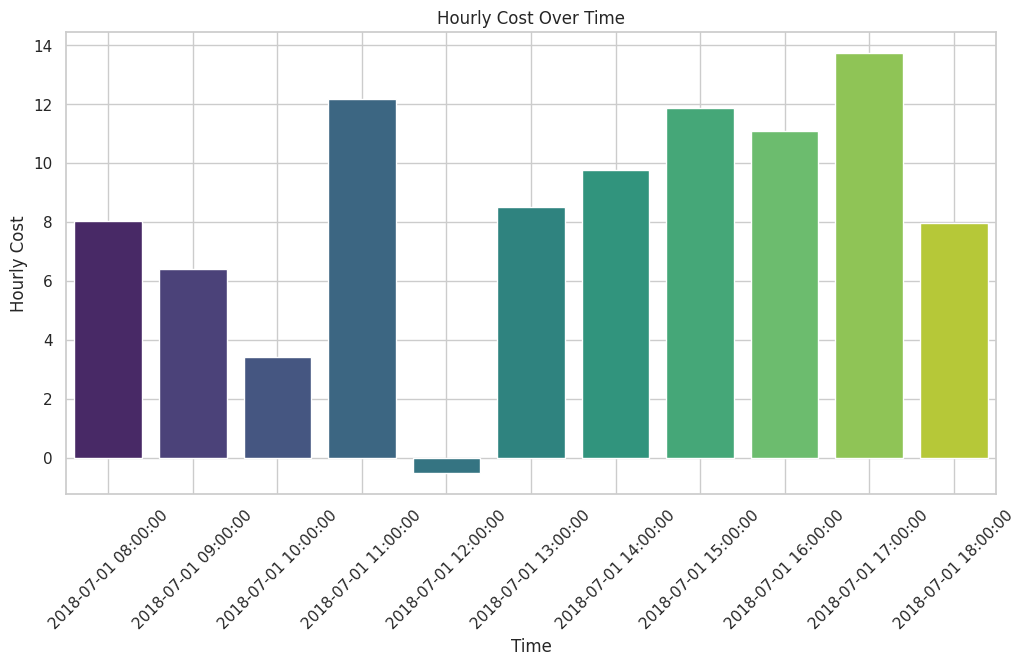

In [138]:
df_filtered, total_cost = calculate_cost(df, start_time, end_time)
print(f'Total Cost from {start_time} to {end_time}: {total_cost:.2f}')
visualize_cost(df_filtered)

## 計算 EV 離開時的滿意度

In [118]:
df = pd.read_csv('./Result/VDN/1/charging_records.csv', parse_dates=['arrival_time', 'departure_time'])

In [123]:
def calculate_satisfaction(df):
    # calculate final SoC
    df['satisfaction'] = df['final_soc'] / df['departure_soc']
    df['satisfaction'] = df['satisfaction'].clip(upper=1)  # limit satisfaction to 1
    return df

In [124]:
def visualize_satisfaction(df):
    plt.figure(figsize=(14, 8))
    sns.set_theme(style="whitegrid")
    # use coolwarm color palette
    palette = sns.color_palette("coolwarm", df['requestID'].nunique())
    # create a dictionary to map requestID to color
    lut = dict(zip(df['requestID'].unique(), palette))
    # create a new column 'colors' by mapping requestID to color
    df['colors'] = df['requestID'].map(lut)
    
    # draw barplot
    barplot = sns.barplot(x='requestID', y='satisfaction', data=df, palette=df['colors'].tolist())
    
    # add data labels
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.2f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', 
                         xytext=(0, 10), 
                         textcoords='offset points')

    plt.xticks(rotation=45)
    plt.xlabel('Request ID')
    plt.ylabel('Satisfaction')
    plt.title('User Satisfaction')
    plt.ylim(0, 1.1)  # ensure the y-axis starts from 0 and ends at 1.1
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [125]:
def calculate_average_satisfaction(df):
    # calculate average satisfaction
    average_satisfaction = df['satisfaction'].mean()
    return average_satisfaction

Average Satisfaction: 0.99


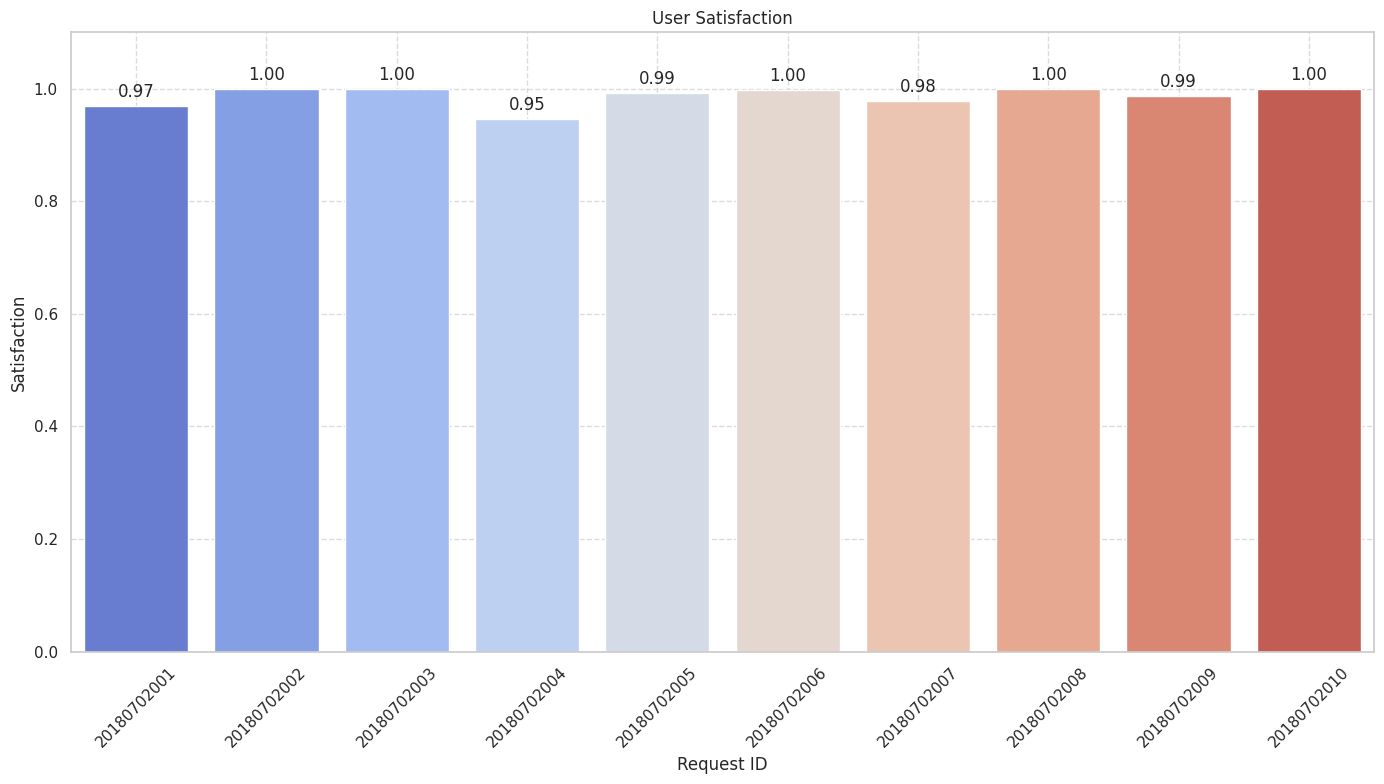

In [126]:
# calculate satisfaction
df = calculate_satisfaction(df)

# calculate average satisfaction
average_satisfaction = calculate_average_satisfaction(df)
print(f'Average Satisfaction: {average_satisfaction:.2f}')

# visualize satisfaction
visualize_satisfaction(df)